In [1]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.disable_v2_behavior()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [35]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


##### Set the path to directory containing code of this case (conditioning to global features alone)

In [2]:
new_path = 'C:\\Users\\Windows\\Documents\\LTrace\\GeoModeling_GANSim-2D_Condition_to_Well_Facies_and_Global_Features\\Code\\0_only_conditioning_to_global_features\\'
sys.path.append(new_path)

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [3]:
data_dir_test = 'C:\\Users\\Windows\\Documents\\LTrace\\GeoModeling_GANSim-2D_Condition_to_Well_Facies_and_Global_Features\\TrainingData\\'

#### Set path to trained network

In [4]:
# 19200 means totally 19200 thousand training images (facies models) used for the training
network_dir = 'C:\\Users\\Windows\\Documents\\LTrace\\GeoModeling_GANSim-2D_Condition_to_Well_Facies_and_Global_Features\\TrainingResults\\1_GANs conditioned to global features\\903-pgan-CondGlobalFeatures-2gpu\\'
network_name = 'network-snapshot-019520.pkl'

### 1. Fetch dataset

In [5]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset
# tfrecord_dir='TestData' to fetch test dataset, if tfrecord_dir='TrainingData' to fetch training dataset
# labeltypes: 0 for 'channelorientation', 1 for 'mudproportion', 2 for 'channelwidth', 3 for 'channelsinuosity'
# well_enlarge: if True, well points occupy 4x4 area, otherwise occupy 1x1 area
test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', labeltypes = [1,2,3], well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# labels are from -1 to 1
image_test, label_test = test_set.get_minibatch_imageandlabel_np(3000)  
probimg_test, wellfacies_test = test_set.get_minibatch_probandwell_np(3000*8)


Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 255]
Label size    = 3


In [6]:
print(image_test.shape)
print(label_test.shape)
print(probimg_test.shape)
print(wellfacies_test.shape)

(3000, 1, 64, 64)
(3000, 3)
(24000, 1, 64, 64)
(24000, 1, 64, 64)


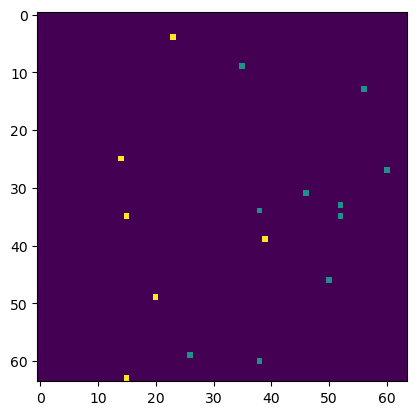

In [7]:
plt.imshow(wellfacies_test[55,0])

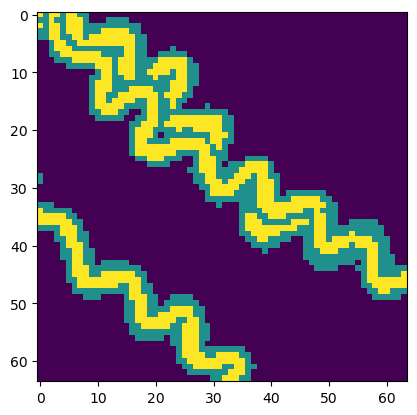

In [8]:
plt.imshow(image_test[60,0])

#### Global features are kept and inputted into Networks with the scale of -1 to 1. To recover the global features into its original scales, use the below transformation functions.


In [9]:
#orit_test = (label_test[:,0]/2+0.5)*168-84
back_ratio_test = (label_test[:,0]/2+0.5)*0.8037109375+0.167724609375
width_test = (label_test[:,1]/2+0.5)*0.8+2.7
amwv_ratio_test = (label_test[:,2]/2+0.5)*0.4866197183098592+0.06338028169014084

### 2. Import pre-trained Network

In [10]:
network_dir+network_name

'C:\\Users\\Windows\\Documents\\LTrace\\GeoModeling_GANSim-2D_Condition_to_Well_Facies_and_Global_Features\\TrainingResults\\1_GANs conditioned to global features\\903-pgan-CondGlobalFeatures-2gpu\\network-snapshot-019520.pkl'

In [11]:
# Initialize TensorFlow session.
tf.InteractiveSession()

# Import networks.
with open(network_dir+network_name, 'rb') as file:
    G, D, Gs = pickle.load(file)

c:\Users\Windows\anaconda3\envs\gansim\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [12]:
print(Gs.input_shapes)

[[None, 128], [None, 3]]




### 3. Quanlitative evaluation of the imported pretrained Generator



#### (1) Random simulation conditioned to given global features from test dataset

First column is the test ground truth facies models, other columns are generated facies models with the same global features (mud proportion, channel sinuosity, and channel sand width) as the corresponding test facies models of the first column. Facies models in a row have the same input global features.

Generated facies models vary from -1 to 1: -1 is mud facies, 0 is channel bank, and 1 is channel sand

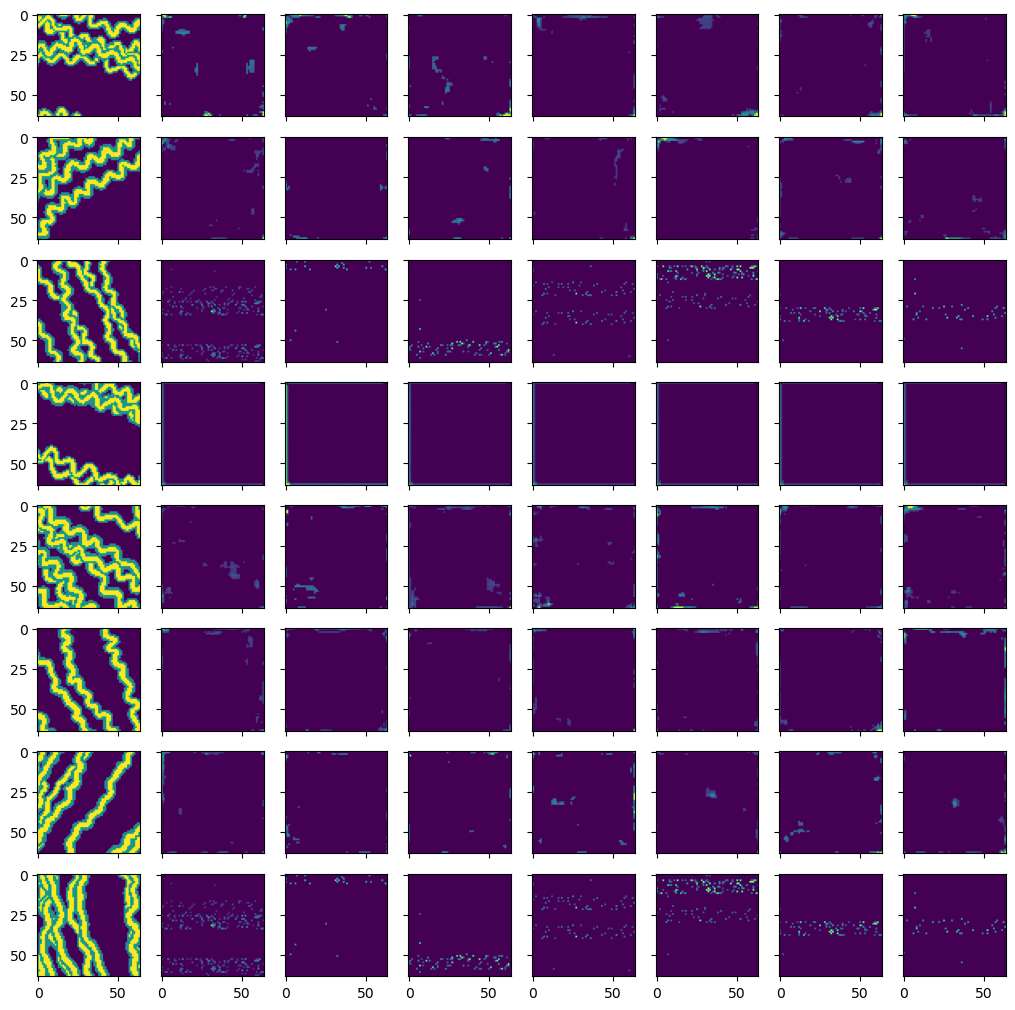

In [13]:
fig, ax = plt.subplots(8, 8, sharex='col', sharey='row')
fig.set_size_inches(12.5, 12.5, forward=True)

for i in range (8):
    ax[i, 0].imshow(image_test[i,0,:,:])
    
    # Generate latent vectors.
    latents_plt = np.random.randn(7, Gs.input_shapes[0][1])
    labels_plt = np.expand_dims(label_test[i], axis=0)
    labels_plt = np.repeat(labels_plt, 7, axis=0)

    # Run the generator to produce a set of images.
    images_plt = Gs.run(latents_plt, labels_plt)
    images_plt = np.where(images_plt< -0.7, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt> -0.4) & (images_plt< 0.4), 0, images_plt)

    for j in range(1,8):
        ax[i, j].imshow(images_plt[j-1,0,:,:])
    
#plt.savefig(network_dir + "simulations conditioned to labels.png", dpi=200) 

#### (2) Generate facies models with increasing input sinuosity index and increasing input inter-channel mud facies ratio

##### Choose appropriate increasing global features from test data

These chosen global features will be used to simulate facies models; these facies models will be compared to facies models with the same global features in test dataset

In [14]:
back_ratio_no = 8
amwv_ratio_no = 4


In [15]:
back_ratio_test_max = np.max(back_ratio_test)
back_ratio_test_min = np.min(back_ratio_test)
amwv_ratio_test_max = np.max(amwv_ratio_test)
amwv_ratio_test_min = np.min(amwv_ratio_test)

plot_img_no = np.empty((back_ratio_no, amwv_ratio_no), dtype = np.int)
a = np.arange(back_ratio_test.shape[0])
np.random.shuffle(a)
for i in range (back_ratio_no):
    for j in range(amwv_ratio_no):
        for r in range(back_ratio_test.shape[0]):
            k = a[r]            
            if back_ratio_test[k] > (back_ratio_test_max - back_ratio_test_min) * i/back_ratio_no+back_ratio_test_min and \
            back_ratio_test[k] < (back_ratio_test_max - back_ratio_test_min) * (i+1)/back_ratio_no+back_ratio_test_min and \
            amwv_ratio_test[k] > (amwv_ratio_test_max - amwv_ratio_test_min) * j/amwv_ratio_no+amwv_ratio_test_min and \
            amwv_ratio_test[k] < (amwv_ratio_test_max - amwv_ratio_test_min) * (j+1)/amwv_ratio_no +amwv_ratio_test_min and \
            width_test[k] >= 3 and width_test[k] <3.2 and (k not in plot_img_no): 
                plot_img_no[i, j] = k
                break

In [16]:
print(plot_img_no)

[[          0  1069547520  -182764566        1484]
 [-1078310938        2742         376          10]
 [       1648         377         933         468]
 [       2036         461          18         962]
 [       1981         490        1336        2754]
 [        966        1183         200        2440]
 [       1992        1791        2482        2328]
 [       2697        1417        2561        1028]]


#### Simulate with the above chosen appropriate global features

In [17]:
plot_img_no = plot_img_no[2:7]

c:\Users\Windows\anaconda3\envs\gansim\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == "__main__":


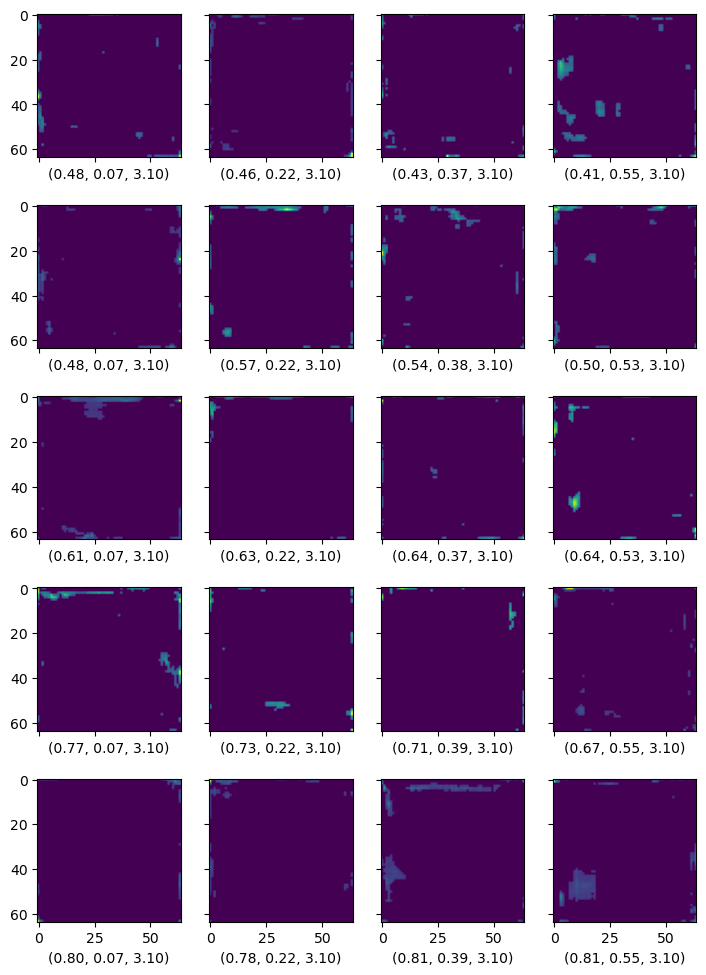

In [18]:
fig, ax = plt.subplots(5, 4, sharex='col', sharey='row')
fig.set_size_inches(8.5, 12, forward=True)

# Generate latent vectors.
np.random.seed(113)
latents_plt = np.random.randn(5 * 4, Gs.input_shapes[0][1]) # 1000 random latents *Gs.input_shapes = [None, 128] [None, 4] [None, 1, 64, 64]

img_nos = plot_img_no.reshape(1, -1).tolist()
labels_plt = label_test[img_nos]

# Run the generator to produce a set of images.
images_plt = Gs.run(latents_plt, labels_plt)
images_plt = np.where(images_plt< -0.7, -1, images_plt)
images_plt = np.where(images_plt> 0.3, 1, images_plt)

for i in range (5):
  for j in range(4):
    ax[i, j].imshow(images_plt[i*4 + j,0,:,:])
    ax[i, j].set_xlabel('({:.2f}, {:.2f}, {:.2f})'.format(back_ratio_test[plot_img_no[i,j]], amwv_ratio_test[plot_img_no[i,j]], width_test[plot_img_no[i,j]]))
#plt.savefig(network_dir + "back_ratio vs amwv_ratio-Simulated.png", dpi=200)    

#### Show facies models in Test dataset with the same global features as the simulated images

c:\Users\Windows\anaconda3\envs\gansim\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


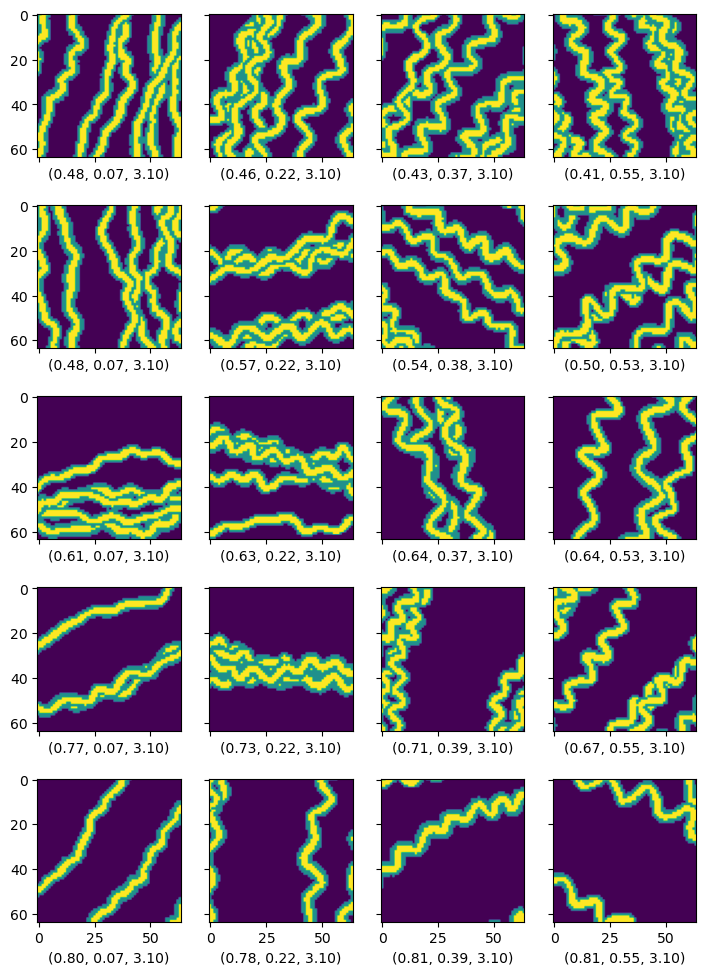

In [19]:
fig, ax = plt.subplots(5, 4, sharex='col', sharey='row')
fig.set_size_inches(8.5, 12, forward=True)


img_nos = plot_img_no.reshape(1, -1).tolist()

# Run the generator to produce a set of images.
images_plt = image_test[img_nos]
for i in range (5):
  for j in range(4):
    ax[i, j].imshow(images_plt[i*4 + j,0,:,:])
    ax[i, j].set_xlabel('({:.2f}, {:.2f}, {:.2f})'.format(back_ratio_test[plot_img_no[i,j]], amwv_ratio_test[plot_img_no[i,j]], width_test[plot_img_no[i,j]]))
#plt.savefig(network_dir + "back_ratio vs amwv_ratio-Simulated.png", dpi=200)    

#### (3) Generate facies models with increasing input sinuosity index and increasing input channel sand width ratio
##### Choose appropriate increasing global features from test data

In [20]:
width_no = 3
amwv_ratio_no = 4

In [21]:
width_test_max = np.max(width_test)
width_test_min = np.min(width_test)
amwv_ratio_test_max = np.max(amwv_ratio_test)
amwv_ratio_test_min = np.min(amwv_ratio_test)


plot_img_no = np.empty((width_no, amwv_ratio_no), dtype = np.int)
a = np.arange(back_ratio_test.shape[0])
np.random.shuffle(a)
for i in range (width_no):   
  for j in range(amwv_ratio_no):
    for r in range(back_ratio_test.shape[0]):
      k = a[r]  
    
      if width_test[k] >= (width_test_max - width_test_min) * i/width_no +width_test_min  and \
         width_test[k] <= (width_test_max - width_test_min) * (i+1)/width_no+width_test_min and \
         amwv_ratio_test[k] >= (amwv_ratio_test_max - amwv_ratio_test_min) * j/amwv_ratio_no+amwv_ratio_test_min and \
         amwv_ratio_test[k] < (amwv_ratio_test_max - amwv_ratio_test_min) * (j+1)/amwv_ratio_no+amwv_ratio_test_min and \
         back_ratio_test[k] >= 0.5 and back_ratio_test[k] <0.6 and (k not in plot_img_no):         
         
        plot_img_no[i, j] = k
        break

In [22]:
print(plot_img_no)

[[1029 2213  319 1664]
 [1724 1603 1633  127]
 [2424 2608 1132 1966]]


##### Simulate with the above chosen appropriate global features

c:\Users\Windows\anaconda3\envs\gansim\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


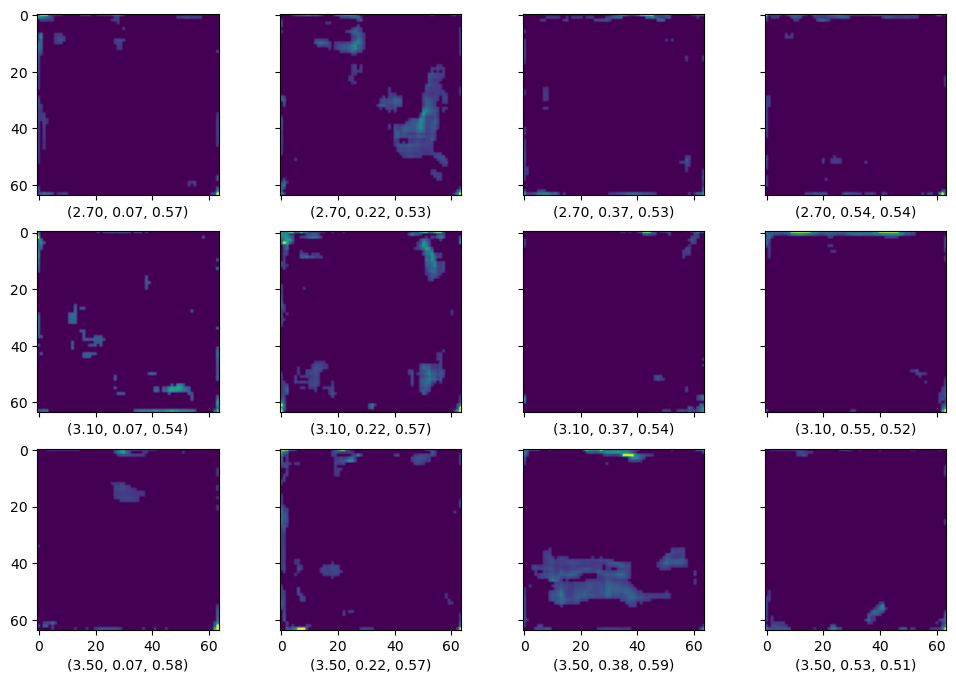

In [23]:
fig, ax = plt.subplots(3, 4, sharex='col', sharey='row')
fig.set_size_inches(12, 8, forward=True)

# Generate latent vectors.
latents_plt = np.random.RandomState(356).randn(3 * 4, Gs.input_shapes[0][1]) # 1000 random latents *Gs.input_shapes = [None, 128] [None, 4] [None, 1, 64, 64]

img_nos = plot_img_no.reshape(1, -1).tolist()
labels_plt = label_test[img_nos]
#labels_plt[:,1] = 0.25

# Run the generator to produce a set of images.
images_plt = Gs.run(latents_plt, labels_plt)
images_plt = np.where(images_plt< -0.7, -1, images_plt)
images_plt = np.where(images_plt> 0.3, 1, images_plt)

for i in range (3):
  for j in range(4):
    ff = ax[i, j].imshow(images_plt[i*4 + j,0,:,:])
    ax[i, j].set_xlabel('({:.2f}, {:.2f}, {:.2f})'.format(width_test[plot_img_no[i,j]], amwv_ratio_test[plot_img_no[i,j]], back_ratio_test[plot_img_no[i,j]]))
    
#plt.savefig(network_dir + "width vs amwv_ratio_fake-Simulated.png", dpi=200)   

##### Show facies models in Test dataset with the same global features as the simulated images

c:\Users\Windows\anaconda3\envs\gansim\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


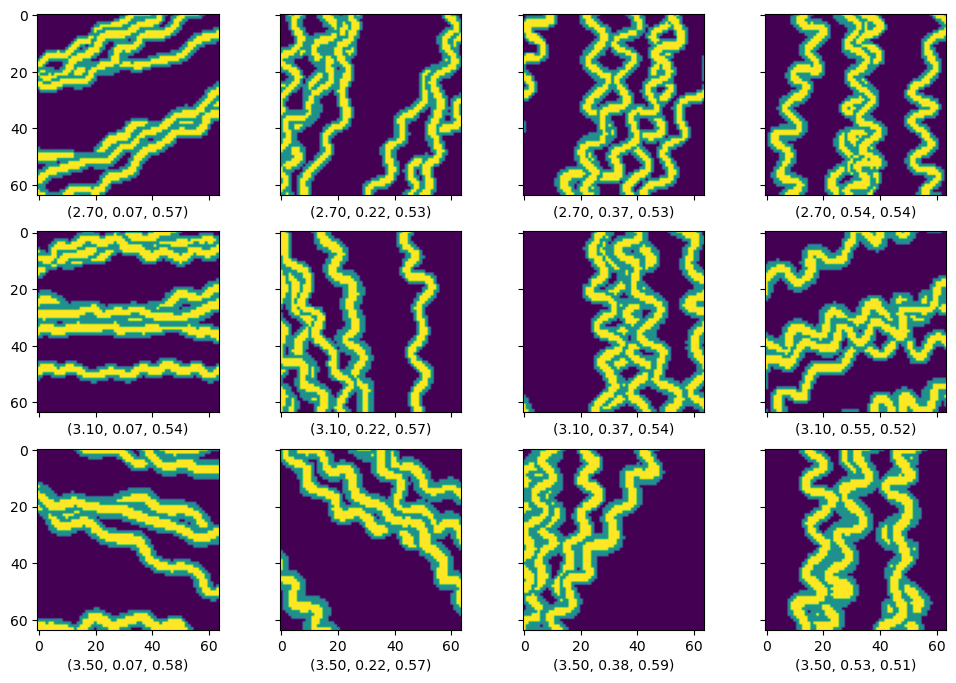

In [24]:
fig, ax = plt.subplots(3, 4, sharex='col', sharey='row')
fig.set_size_inches(12, 8, forward=True)

img_nos = plot_img_no.reshape(1, -1).tolist()

# Run the generator to produce a set of images.
images_plt = image_test[img_nos]
for i in range (3):
  for j in range(4):
    ff = ax[i, j].imshow(images_plt[i*4 + j,0,:,:])
    ax[i, j].set_xlabel('({:.2f}, {:.2f}, {:.2f})'.format(width_test[plot_img_no[i,j]], amwv_ratio_test[plot_img_no[i,j]], back_ratio_test[plot_img_no[i,j]]))
    
#plt.savefig(network_dir + "width vs amwv_ratio_fake-Simulated.png", dpi=200)   

** (4) Random simulation conditioned to user set global features**

global features ("labels") = user set followed by normalization

random latents =  from random normal distribution

In [25]:
# User set global features: 
back_ratio_user = 0.65 # in range (0.05, 0.8)
width_user = 3  # in range (2, 4) meters, each pixel is 10 meters.
amwv_ratio_user = 0.36 # in range (0.05, 0.90) amplitude/wavelength ratio

# As input global features should at range -1 to 1, these user-set global features should adjusted into (-1,1) range.
back_ratio_user_norm = ((back_ratio_user - back_ratio_test_min)/(back_ratio_test_max - back_ratio_test_min) - 0.5) * 2
width_user_norm = ((width_user - width_test_min)/(width_test_max - width_test_min) - 0.5) * 2
amwv_ratio_user_norm = ((amwv_ratio_user  - amwv_ratio_test_min)/(amwv_ratio_test_max - amwv_ratio_test_min) - 0.5) * 2

labels_user = np.array([back_ratio_user_norm, width_user_norm, amwv_ratio_user_norm])

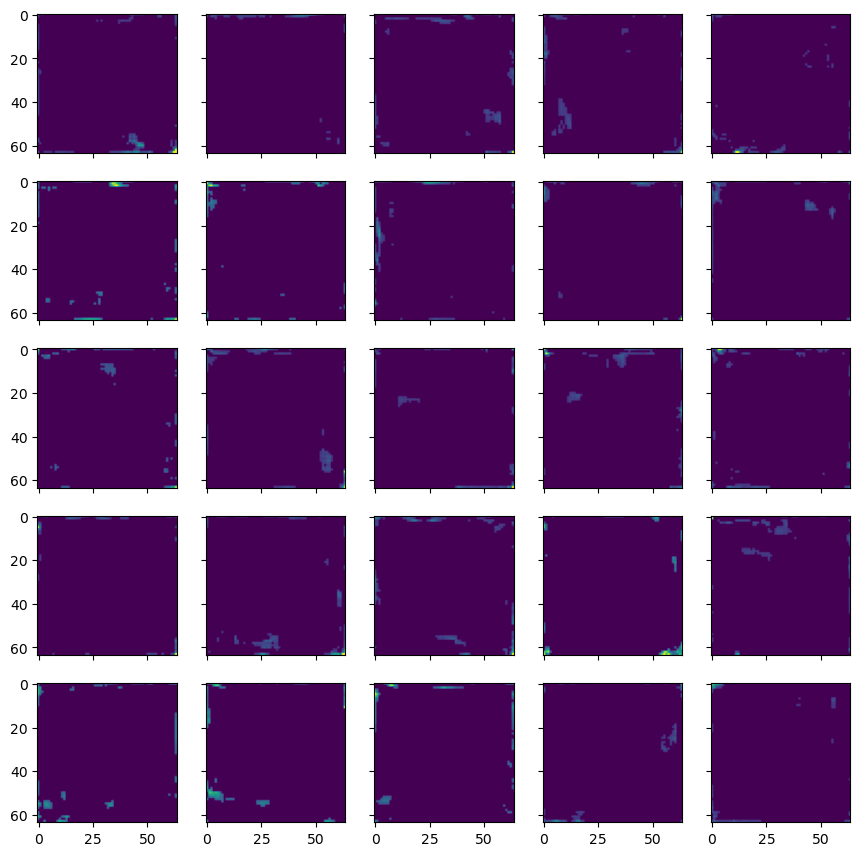

In [26]:
fig, ax = plt.subplots(5, 5, sharex='col', sharey='row')
fig.set_size_inches(10.5, 10.5, forward=True)

latents_user_plt = np.random.randn(5 * 5, Gs.input_shapes[0][1])
labels_user_plt = np.repeat(np.expand_dims(labels_user, axis=0), 5 * 5, axis=0)

# Run the generator to produce a set of images.
images_user_plt = Gs.run(latents_user_plt, labels_user_plt)
images_user_plt = np.where(images_user_plt< -0.7, -1, images_user_plt)
images_user_plt = np.where(images_user_plt> 0.3, 1, images_user_plt)

for i in range (5):
  for j in range(5):
    ax[i, j].imshow(images_user_plt[i*5 + j,0,:,:])
    
#plt.savefig(network_dir + "simulations conditioned to user set global features.png", dpi=200) 

### 4. Quantitative evaluation of the imported pretrained Generator


####  (1) Assess inter-channel mud facies ratio

In [27]:
back_ratio_no = 500
a = np.arange(back_ratio_test.shape[0])
np.random.shuffle(a)
plot_img_no = a[:back_ratio_no]

In [28]:

# Generate latent vectors.
latents_plt = np.random.RandomState(61).randn(back_ratio_no, Gs.input_shapes[0][1]) # 1000 random latents *Gs.input_shapes[0][1:]=[None, 128] [None, 4]

img_nos = plot_img_no.reshape(1, -1).tolist()
labels_plt = label_test[img_nos]

# Run the generator to produce a set of images.
images_plt = Gs.run(latents_plt, labels_plt)


test_fake_back_ratio = 1-np.count_nonzero(np.where(images_plt >=-0.7,1,0), (1,2,3))/(64*64)
test_real_back_ratio = back_ratio_test[img_nos]

c:\Users\Windows\anaconda3\envs\gansim\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """
c:\Users\Windows\anaconda3\envs\gansim\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == "":


y=0.011755x+(0.959949)


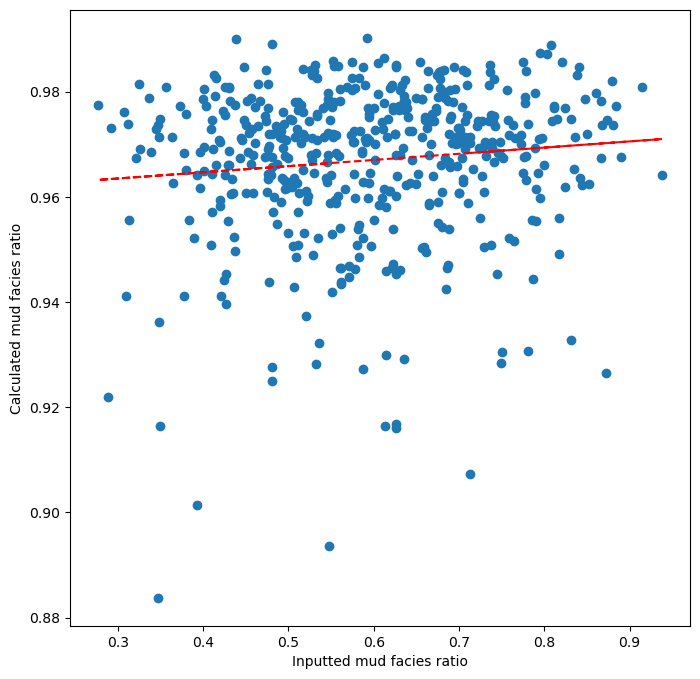

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8, forward=True)

ax.scatter(test_real_back_ratio, test_fake_back_ratio)
# calc the trendline
z = np.polyfit(test_real_back_ratio, test_fake_back_ratio, 1)
p = np.poly1d(z)
plt.plot(test_real_back_ratio,p(test_real_back_ratio),"r--")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

ax.set_xlabel("Inputted mud facies ratio")
ax.set_ylabel("Calculated mud facies ratio")
plt.savefig(network_dir +"Mud facies ratio scatter of fake vs real.png", dpi=200)   

#### (2) Assess channel width

#### First quantitative evaluation method in paper.
##### 1) With random input global features, generate facies models;
##### 2) Use image process toolbox in Matlab to measure the channel sand width for each facies model;
##### 3) Calculate the relationship between input and calculated global features

#### Second quantitative evaluation method in paper.
##### 1) With input global features from test dataset, generate a number of facies model realizations;
##### 2) Use image process toolbox in Matlab to measure the channel sand width for each generated facies model and the real facies model in test dataset;
##### 3) Use blox plot to compare the distribution of calculated global features from the generated facies models and the real facies models from test dataset.


#### (3) Assess channel sinuosity index
##### Same way as assessing channel sand sinuosity index
##### The different is that, in Matlab, we calculate the channel arc length to straight-line length ratio

###  5. Evaluation of the imported pretrained Discriminator as a global feature recognizer


#### Assess D with Test data

In [30]:
plt_data_no = 500
a = np.arange(plt_data_no)
np.random.shuffle(a)
test_img_no = a[:plt_data_no]
_, features = D.run(image_test[test_img_no]/127.5-1)

y=0.005459x+(0.562257)
y=-0.004973x+(3.072611)
y=0.003284x+(0.466992)


Text(0, 0.5, 'Predicted amplitude/wavelength ratio by D')

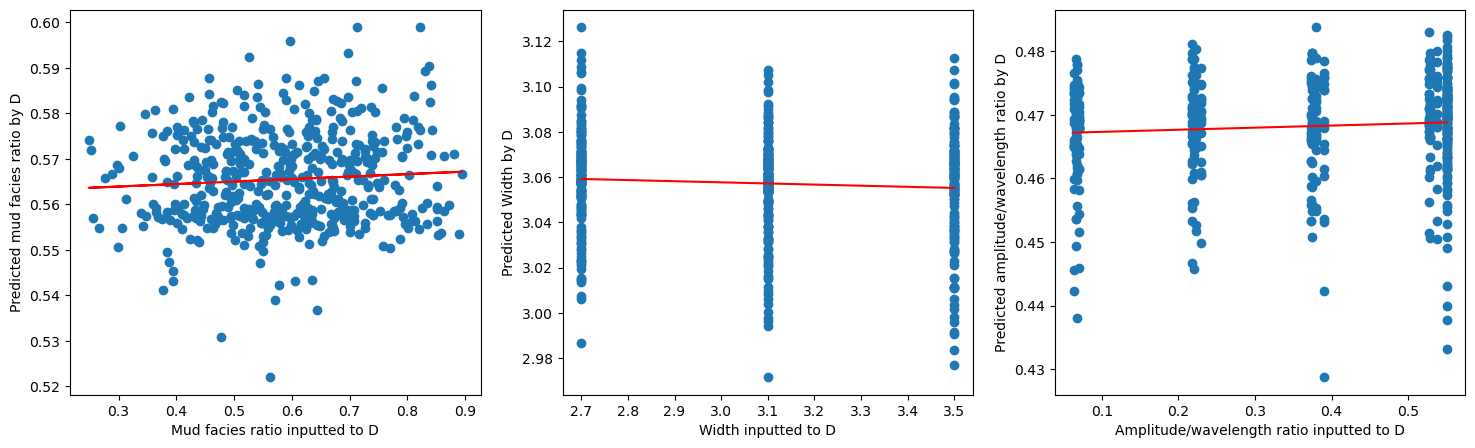

In [31]:
features[:, 0] = (features[:, 0] / 2 + 0.5) * (back_ratio_test_max - back_ratio_test_min) + back_ratio_test_min
features[:, 1] = (features[:, 1] / 2 + 0.5) * (width_test_max - width_test_min) + width_test_min
features[:, 2] = (features[:, 2] / 2 + 0.5) * (amwv_ratio_test_max - amwv_ratio_test_min) + amwv_ratio_test_min

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18, 5, forward=True)

# (back_ratio[test_image_num], width[test_image_num], amwv_ratio[test_image_num]) 
# labels_cor includes: orientation, background_ratio, width, amplitude/wavelength ratio, after shifting to (-1, 1)
ax[0].scatter(back_ratio_test[test_img_no], features[:, 0]) 
# calc the trendline
z1 = np.polyfit(back_ratio_test[test_img_no], features[:, 0], 1)
p1 = np.poly1d(z1)
ax[0].plot(back_ratio_test[test_img_no],p1(back_ratio_test[test_img_no]),"r-")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z1[0],z1[1]))
ax[0].set_xlabel("Mud facies ratio inputted to D")
ax[0].set_ylabel("Predicted mud facies ratio by D")

# labels_cor includes: orientation, background_ratio, width, amplitude/wavelength ratio, after shifting to (-1, 1)
ax[1].scatter(width_test[test_img_no], features[:, 1]) 
# calc the trendline
z2 = np.polyfit(width_test[test_img_no], features[:, 1], 1)
p2 = np.poly1d(z2)
ax[1].plot(width_test[test_img_no],p2(width_test[test_img_no]),"r-")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z2[0],z2[1]))
ax[1].set_xlabel("Width inputted to D")
ax[1].set_ylabel("Predicted Width by D")

# labels_cor includes: orientation, background_ratio, width, amplitude/wavelength ratio, after shifting to (-1, 1)
ax[2].scatter(amwv_ratio_test[test_img_no], features[:, 2]) 
# calc the trendline
z3 = np.polyfit(amwv_ratio_test[test_img_no], features[:, 2], 1)
p3 = np.poly1d(z3)
ax[2].plot(amwv_ratio_test[test_img_no],p3(amwv_ratio_test[test_img_no]),"r-")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z3[0],z3[1]))
ax[2].set_xlabel("Amplitude/wavelength ratio inputted to D")
ax[2].set_ylabel("Predicted amplitude/wavelength ratio by D")
#plt.savefig(network_dir +"Mud facies ratio scatter of fake vs real.png", dpi=200)   

#### Assess D with Simulated data
*(1) Randomly Select global features data

In [32]:
# Generate latent vectors.
latents_plt = np.random.randn(plt_data_no, Gs.input_shapes[0][1]) # 1000 random latents *Gs.input_shapes[0][1:]=[None, 128] [None, 4]

labels_plt = np.random.uniform(-1, 1, (plt_data_no, Gs.input_shapes[1][1]))

# Run the generator to produce a set of images.
images_plt = Gs.run(latents_plt, labels_plt)
images_plt = np.where(images_plt< -0.7, -1, images_plt)
images_plt = np.where(images_plt> 0.3, 1, images_plt)

_, features = D.run(images_plt)


y=0.000319x+(0.567361)
y=0.000672x+(3.057481)
y=-0.002843x+(0.467017)


Text(0, 0.5, 'Predicted amplitude/wavelength ratio by D')

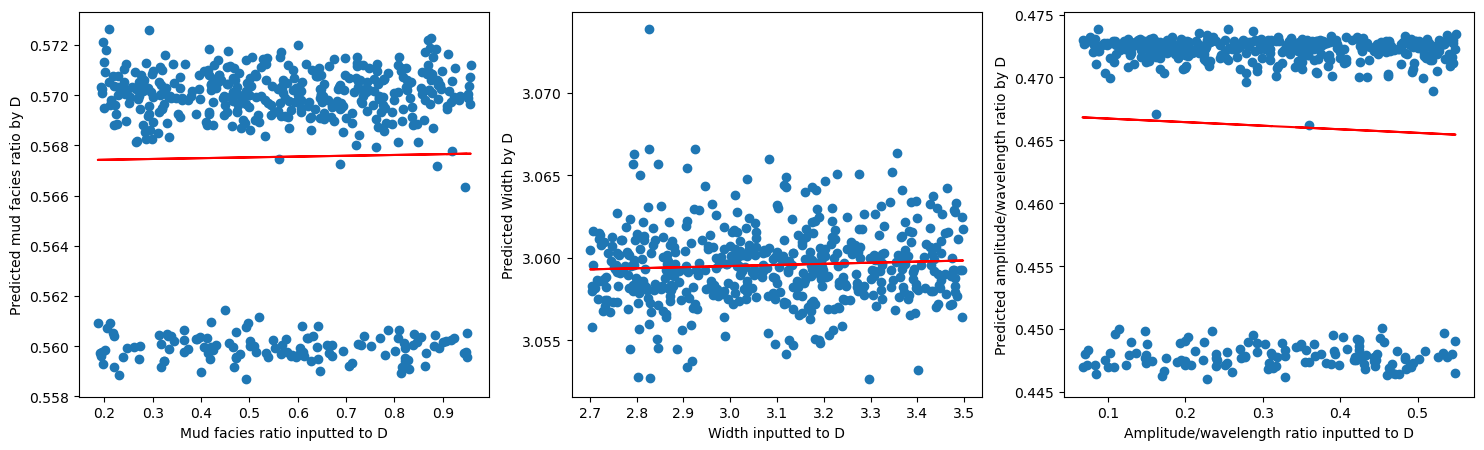

In [33]:
features[:, 0] = (features[:, 0] / 2 + 0.5) * (back_ratio_test_max - back_ratio_test_min) + back_ratio_test_min
features[:, 1] = (features[:, 1] / 2 + 0.5) * (width_test_max - width_test_min) + width_test_min
features[:, 2] = (features[:, 2] / 2 + 0.5) * (amwv_ratio_test_max - amwv_ratio_test_min) + amwv_ratio_test_min

labels_plt[:, 0] = (labels_plt[:, 0] / 2 + 0.5) * (back_ratio_test_max - back_ratio_test_min) + back_ratio_test_min
labels_plt[:, 1] = (labels_plt[:, 1] / 2 + 0.5) * (width_test_max - width_test_min) + width_test_min
labels_plt[:, 2] = (labels_plt[:, 2] / 2 + 0.5) * (amwv_ratio_test_max - amwv_ratio_test_min) + amwv_ratio_test_min

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18, 5, forward=True)

# labels_cor includes: orientation, background_ratio, width, amplitude/wavelength ratio, after shifting to (-1, 1)
ax[0].scatter(labels_plt[:, 0], features[:, 0]) 
# calc the trendline
z1 = np.polyfit(labels_plt[:, 0], features[:, 0], 1)
p1 = np.poly1d(z1)
ax[0].plot(labels_plt[:, 0],p1(labels_plt[:, 0]),"r-")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z1[0],z1[1]))
ax[0].set_xlabel("Mud facies ratio inputted to D")
ax[0].set_ylabel("Predicted mud facies ratio by D")

# labels_cor includes: orientation, background_ratio, width, amplitude/wavelength ratio, after shifting to (-1, 1)
ax[1].scatter(labels_plt[:, 1], features[:, 1]) 
# calc the trendline
z2 = np.polyfit(labels_plt[:, 1], features[:, 1], 1)
p2 = np.poly1d(z2)
ax[1].plot(labels_plt[:, 1],p2(labels_plt[:, 1]),"r-")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z2[0],z2[1]))
ax[1].set_xlabel("Width inputted to D")
ax[1].set_ylabel("Predicted Width by D")

# labels_cor includes: orientation, background_ratio, width, amplitude/wavelength ratio, after shifting to (-1, 1)
ax[2].scatter(labels_plt[:, 2], features[:, 2]) 
# calc the trendline
z3 = np.polyfit(labels_plt[:, 2], features[:, 2], 1)
p3 = np.poly1d(z3)
ax[2].plot(labels_plt[:, 2],p3(labels_plt[:, 2]),"r-")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z3[0],z3[1]))
ax[2].set_xlabel("Amplitude/wavelength ratio inputted to D")
ax[2].set_ylabel("Predicted amplitude/wavelength ratio by D")
#plt.savefig(network_dir +"Mud facies ratio scatter of fake vs real.png", dpi=200)   